# 1. Quora Insincere Questions Classification
#### Detect toxic content to improve online conversations

#### Description:


<img src="quoa.jpeg" />

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

In this competition, Kagglers will develop models that identify and flag insincere questions. To date, Quora has employed both machine learning and manual review to address this problem. With your help, they can develop more scalable methods to detect toxic and misleading content.

Here's your chance to combat online trolls at scale. Help Quora uphold their policy of “Be Nice, Be Respectful” and continue to be a place for sharing and growing the world’s knowledge.

#### Evaluation :

Submissions are evaluated on F1 Score between the predicted and the observed targets.

#### Idea about the problem:


*An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:*
*  Has a non-neutral tone
*  Has an exaggerated tone to underscore a point about a group of people
*  Is rhetorical and meant to imply a statement about a group of people
*  Is disparaging or inflammatory
*  Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
*  Makes disparaging attacks/insults against a specific person or group of people
*  Based on an outlandish premise about a group of people
*  Disparages against a characteristic that is not fixable and not measurable
*  Isn't grounded in reality
*  Based on false information, or contains absurd assumptions
*  Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.



#### File descriptions
*  train.csv - the training set
*  test.csv - the test set
*  sample_submission.csv - A sample submission in the correct format


#### Data fields
*  qid - unique question identifier
*  question_text - Quora question text
*  target - a question labeled "insincere" has a value of 1, otherwise 0

    

#### Business Objectives and Constraints
* The cost of a mis-classification can be very high. 
* You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
* No strict latency concerns. 
* Interpretability is partially important.

#### Cedits :
* Kaggle kernels

In [1]:
#loading libraries 
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud


import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

#### Loading the Data
##### Insight into Data provided 

In [2]:
#load the tarin Dataset
train = pd.read_csv("Qtrain.csv")
test= pd.read_csv("Qtest.csv")

In [9]:
#information of train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
qid              1306122 non-null object
question_text    1306122 non-null object
target           1306122 non-null int64
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [5]:
#information of train dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375806 entries, 0 to 375805
Data columns (total 2 columns):
qid              375806 non-null object
question_text    375806 non-null object
dtypes: object(2)
memory usage: 5.7+ MB


In [3]:
#pandas has an options system that lets you customize some aspects of its behaviour, display-related options being those the user is most likely to adjust.
pd.set_option('display.max_colwidth', -1)
pd.option_context("display.max_rows", 1000)

####  Observation:
* There are no missng values 

In [11]:
#size of train and test dataset
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


 * Train dataset had 1306122 rows and 3 columns
 * Test dataset has 375806 rows and 2 columns

In [13]:
#first 5 rows of train dataset
train.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [14]:
# First 5 rows of Test dataset
test.head(5)

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [15]:
train.describe(include='all')

,qid,question_text,target
count,1306122,1306122,1.306122e+06
unique,1306122,1306122,NaN
top,ae3de8fc9fd53c347869,"What exactly is a ""manager or executive"" capac...",NaN
freq,1,1,NaN
mean,NaN,NaN,6.187018e-02
std,NaN,NaN,2.409197e-01
min,NaN,NaN,0.000000e+00
25%,NaN,NaN,0.000000e+00
50%,NaN,NaN,0.000000e+00
75%,NaN,NaN,0.000000e+00


In [16]:
#  check for Duplicated question texts
train.duplicated('question_text').sum(), test.duplicated('question_text').sum()

(0, 0)

##  1.1Exploratory Data Visualisation 

### sample of sincere questions

In [7]:
df = pd.read_csv("Qtrain.csv")
df_0 = df.loc[df['target'] == 0].sample(n=1000)
df_1 = df.loc[df['target'] == 1].sample(n=1000)

df_ = pd.concat([df_0,df_1])
df_ = df_.sort_values(by=["qid"])
with pd.option_context("display.max_rows", 1000):
    display(df_)

,qid,question_text,target
1164,0039309127b72d2c4f7f,How are abrasive minerals classified?,0
2533,007eecf468b79f3f0beb,What can be the treatment for the sores? I usually get it once in a month. It appears usaually near my mouth.,0
2600,0081cd56fe8e926bc12c,Do think like me that mother Russia is better than the pussies of America?,1
3366,00a8167895f512af2d26,"Why doesnt the curvature in space time decrease if the universe is expanding? Since gravity is the curvature in space time, as the universe is expanding the fabric of spacetime must also get stretched and hence force of gravity reduced.",0
3523,00afe7e21ec58cd40ec5,Who shot the sheriff?,1
4789,00ee55dbd7ce63a70ab6,Is immigration to Australia suitable for a computer engineer?,0
4829,00f054c06a06f3aaeafc,Could a disposition be physical?,0
5002,00f8984580c6b365d3b6,Why are white Men so hesitant to marry Black Women but seem to have no problem sleeping with them?,1
5227,0103819d86bc449dace9,I get horny when I see Modiji. How can I use him for my own pleasures?,1
5891,0123e4edef4182a9726f,"When working on my blog, I often find myself sidetracked by other things happening online such as Facebook, email, etc. What are some practical things I can do to keep focused on my writing?",0


### Target distribution
* target - a question labeled "insincere" has a value of 1, otherwise 0

In [8]:
train.groupby('target').count()

,qid,question_text
target,,
0,1225312,1225312
1,80810,80810


In [9]:
train['target'].value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

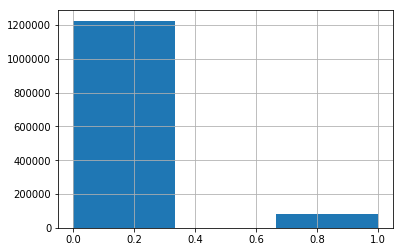

In [10]:
#histogrm of target value distribution
train.target.hist(bins=3)

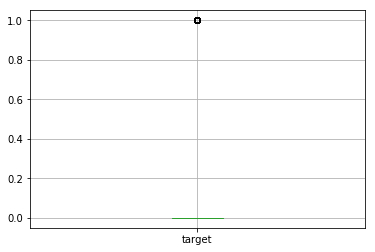

In [11]:
#boxplot of taret value distribution
train[['target']].boxplot()

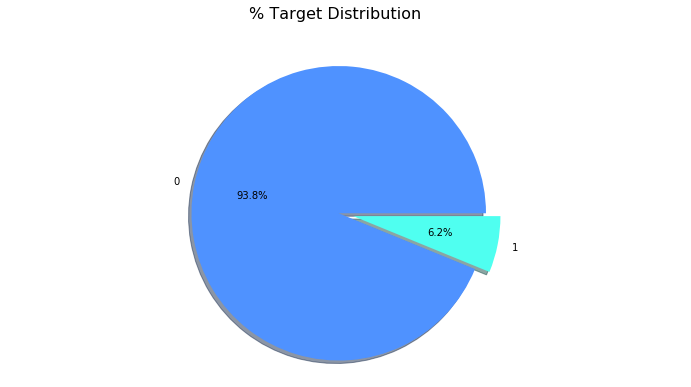

In [6]:
temp = train['target'].value_counts(normalize=True).reset_index()

colors = ['#4f92ff', '#4ffff0']
explode = (0.05, 0.05)
 
plt.pie(temp['target'], explode=explode, labels=temp['index'], colors=colors,
         autopct='%1.1f%%', shadow=True, startangle=0)
 
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.suptitle('% Target Distribution', fontsize=16)
plt.rcParams['font.size'] = 14
plt.axis('equal')
plt.show()

In [12]:
#First 5 rows with target value 0
train[train['target']==0].head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [13]:
#First 5 rows with target value 1
train[train['target']==1].head(5)

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?,1
114,00052793eaa287aff1e1,"I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?",1
115,000537213b01fd77b58a,Which races have the smallest penis?,1


In [14]:
print(train['target'].value_counts())
print(sum(train['target'] == 1) / sum(train['target'] == 0) * 100, "percent of questions are insincere.")
print(100 - sum(train['target'] == 1) / sum(train['target'] == 0) * 100, "percent of questions are sincere")

0    1225312
1    80810  
Name: target, dtype: int64
6.595054973753624 percent of questions are insincere.
93.40494502624638 percent of questions are sincere


In [7]:
def ngram_extractor(text, n_gram):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

# Function to generate a dataframe with n_gram and top max_row frequencies
def generate_ngrams(df, col, n_gram, max_row):
    temp_dict = defaultdict(int)
    for question in df[col]:
        for word in ngram_extractor(question, n_gram):
            temp_dict[word] += 1
    temp_df = pd.DataFrame(sorted(temp_dict.items(), key=lambda x: x[1])[::-1]).head(max_row)
    temp_df.columns = ["word", "wordcount"]
    return temp_df

def comparison_plot(df_1,df_2,col_1,col_2, space):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    
    sns.barplot(x=col_2, y=col_1, data=df_1, ax=ax[0], color="palegreen")
    sns.barplot(x=col_2, y=col_1, data=df_2, ax=ax[1], color="palegreen")

    ax[0].set_xlabel('Word count', size=14, color="green")
    ax[0].set_ylabel('Words', size=14, color="green")
    ax[0].set_title('Top words in sincere questions', size=18, color="green")

    ax[1].set_xlabel('Word count', size=14, color="green")
    ax[1].set_ylabel('Words', size=14, color="green")
    ax[1].set_title('Top words in insincere questions', size=18, color="green")

    fig.subplots_adjust(wspace=space)
    
    plt.show()

#### Top 20 1-gram words in sincere and insincere questions

Sincere questions are dominated by words like best, will, people, good, one, etc. with no reference to any specific nouns. Some of these words are high even in insincere words - meaning they are not significant to the classification.
Insincere questions are dominated by words like trump, women, white, men, indian, muslims, black, americans, girls, indians, sex and india. More reference to specific groups of people of directly a person i.e. Donald Trump.

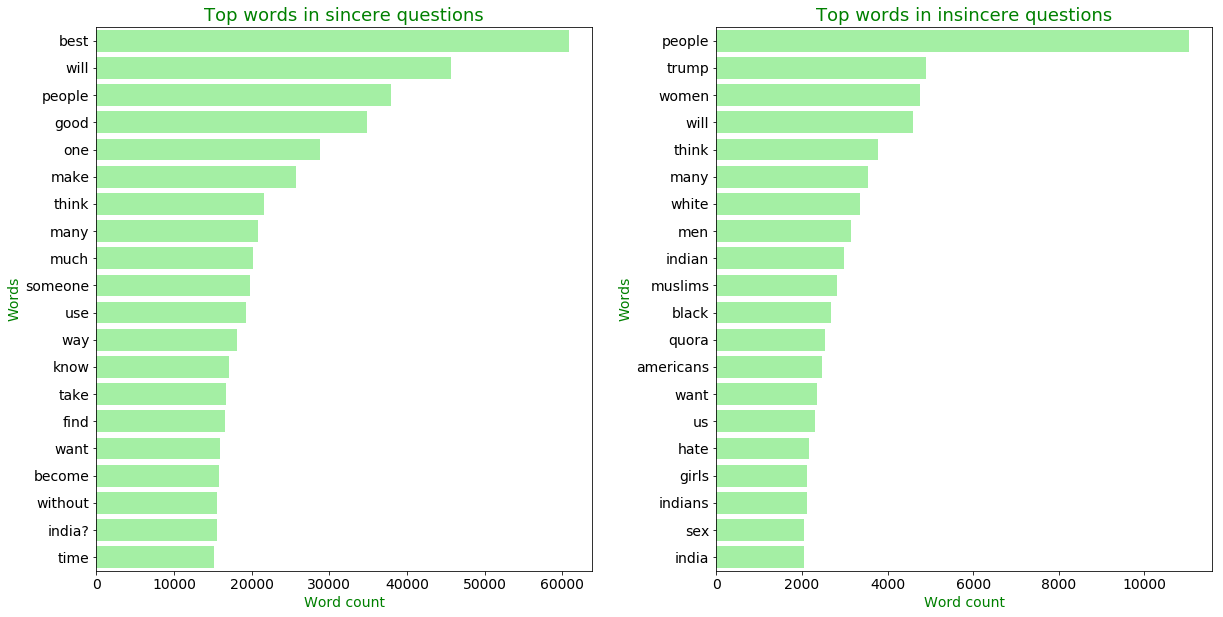

In [10]:
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from collections import defaultdict
import string
sincere_1gram = generate_ngrams(train[train["target"]==0], 'question_text', 1, 20)
insincere_1gram = generate_ngrams(train[train["target"]==1], 'question_text', 1, 20)

comparison_plot(sincere_1gram,insincere_1gram,'word','wordcount', 0.25)

#### Top 20 2-gram words in sincere and insincere questions

Top 3 bigrams in the insincere questions are 'Donald Trump', 'White People' and 'Black People'. Questions related to race are highly insincere.
Presence of Chinese people, Indian muslims, Indian girls, North Indians, Indian women and White Women confirm the same.
Sincere questions have best way, year old, will happen, etc. as the top ones. No clear trend there but 'best' is the key word to look for.

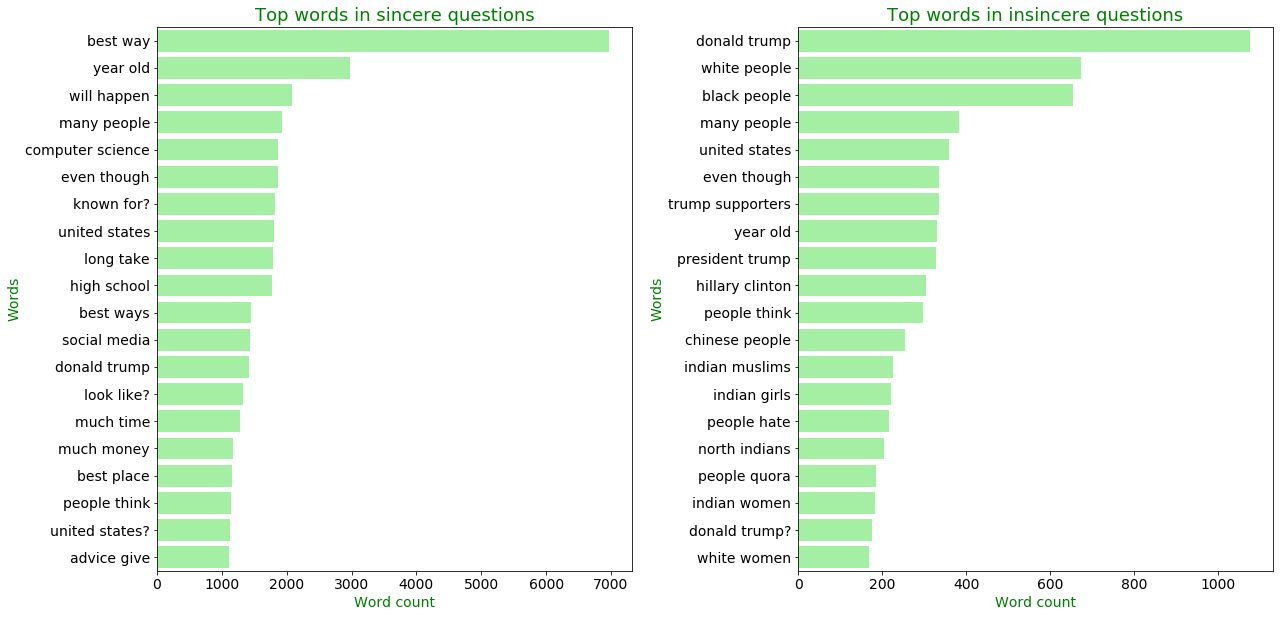

In [11]:
sincere_2gram = generate_ngrams(train[train["target"]==0], 'question_text', 2, 20)
insincere_2gram = generate_ngrams(train[train["target"]==1], 'question_text', 2, 20)

comparison_plot(sincere_2gram,insincere_2gram,'word','wordcount', .35)

#### Top 20 3-gram words in sincere and insincere questions

Insincere questions are related to hypothetical scenarios, age, race, etc
Sincere questions are related to tips, advices, suggestions, facts, etc.

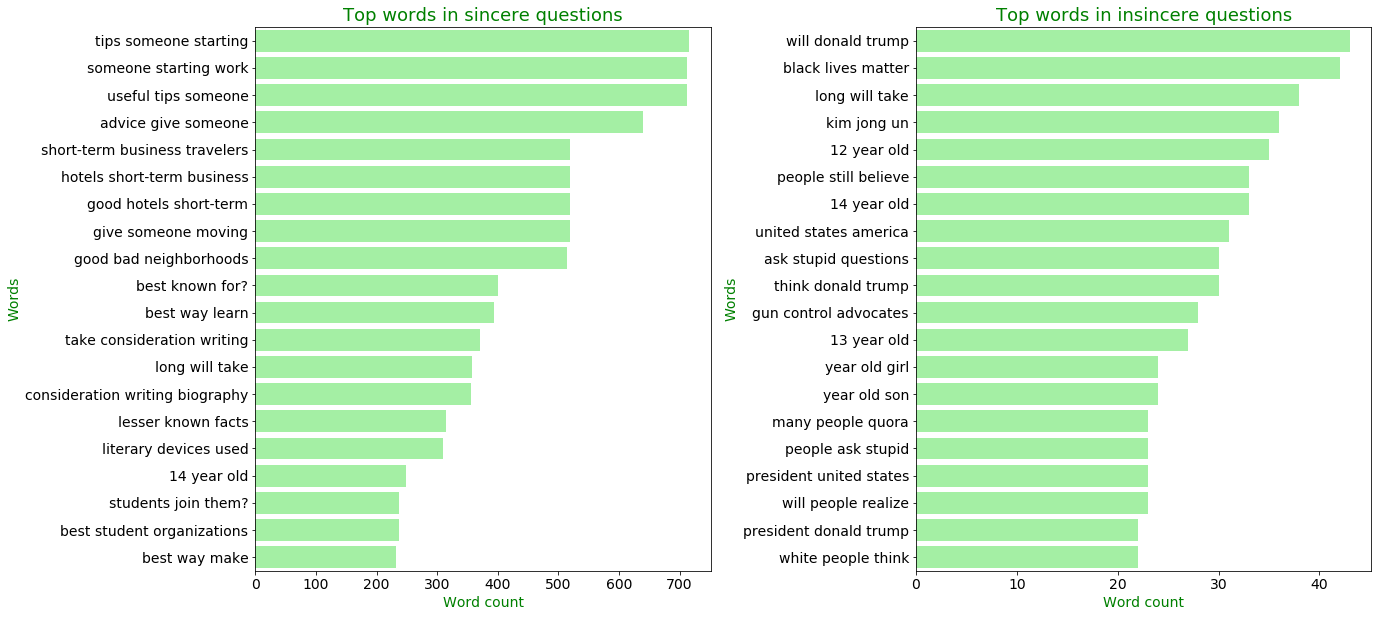

In [12]:
sincere_3gram = generate_ngrams(train[train["target"]==0], 'question_text', 3, 20)
insincere_3gram = generate_ngrams(train[train["target"]==1], 'question_text', 3, 20)

comparison_plot(sincere_3gram,insincere_3gram,'word','wordcount', .45)

### Insincere questions have more words per question

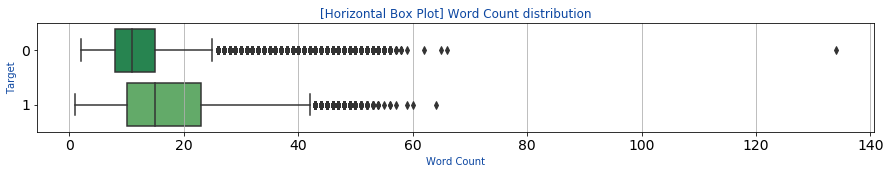

In [13]:
# Number of words in the questions
train["word_count"] = train["question_text"].apply(lambda x: len(str(x).split()))
test["word_count"] = test["question_text"].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="word_count", y="target", data=train, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Word Count distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

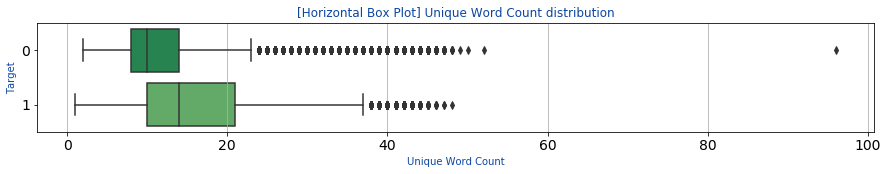

In [14]:
# Number of unique words in the questions
train["unique_word_count"] = train["question_text"].apply(lambda x: len(set(str(x).split())))
test["unique_word_count"] = test["question_text"].apply(lambda x: len(set(str(x).split())))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="unique_word_count", y="target", data=train, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Unique Word Count', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Unique Word Count distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

#### Insincere questions have more characters than sincere questions

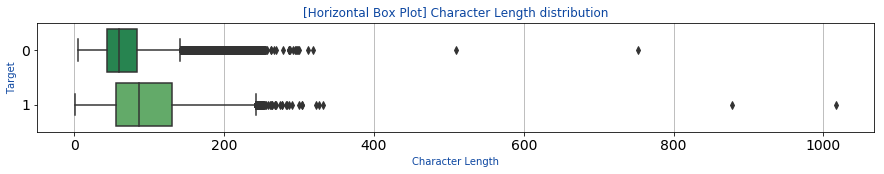

In [15]:
# Number of characters in the questions
train["char_length"] = train["question_text"].apply(lambda x: len(str(x)))
test["char_length"] = test["question_text"].apply(lambda x: len(str(x)))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="char_length", y="target", data=train, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Character Length', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Character Length distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()


#### Insincere questions have more stop words than sincere questions

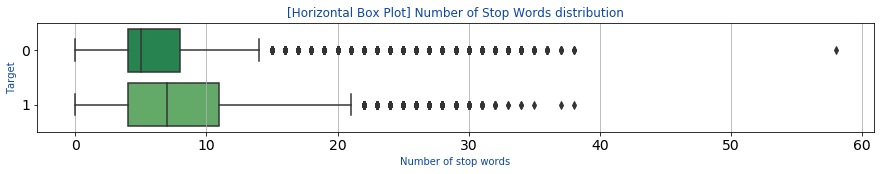

In [17]:
# Number of stop words in the questions
train["stop_words_count"] = train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test["stop_words_count"] = test["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="stop_words_count", y="target", data=train, ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Number of stop words', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Number of Stop Words distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

#### Insincere questions have more punctuations

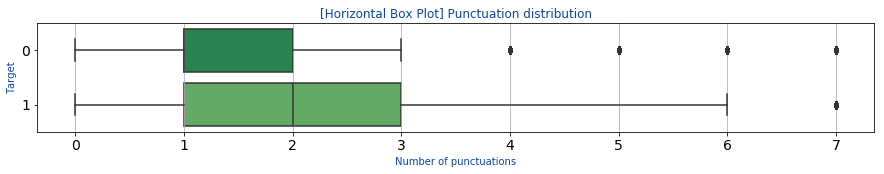

In [18]:
# Number of punctuations in the questions
train["punc_count"] = train["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test["punc_count"] = test["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="punc_count", y="target", data=train[train['punc_count']<train['punc_count'].quantile(.99)], ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Number of punctuations', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Punctuation distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

#### More upper case words in Sincere questions

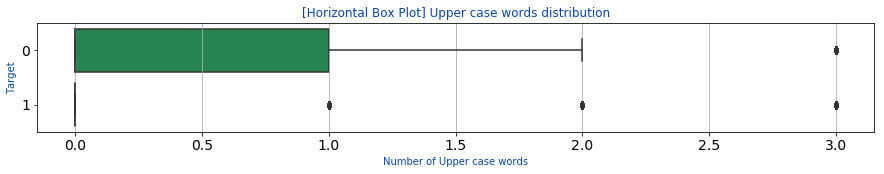

In [20]:
# Number of upper case words in the questions
train["upper_words"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["upper_words"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="upper_words", y="target", data=train[train['upper_words']<train['upper_words'].quantile(.99)], ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Number of Upper case words', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Upper case words distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

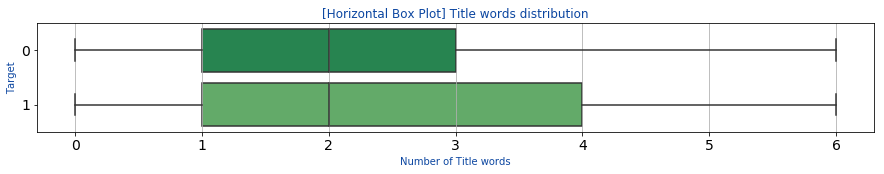

In [21]:
# Number of title words in the questions
train["title_words"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["title_words"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="title_words", y="target", data=train[train['title_words']<train['title_words'].quantile(.99)], ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Number of Title words', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Title words distribution', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

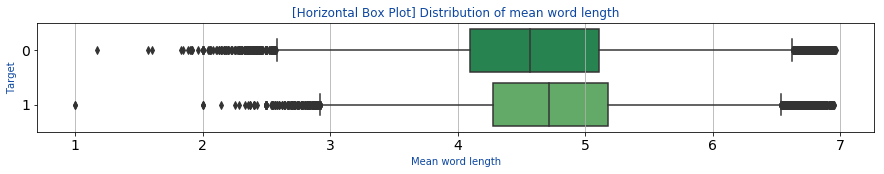

In [22]:
# Mean word length in the questions
train["word_length"] = train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["word_length"] = test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

fig, ax = plt.subplots(figsize=(15,2))
sns.boxplot(x="word_length", y="target", data=train[train['word_length']<train['word_length'].quantile(.99)], ax=ax, palette=sns.color_palette("RdYlGn_r", 10), orient='h')
ax.set_xlabel('Mean word length', size=10, color="#0D47A1")
ax.set_ylabel('Target', size=10, color="#0D47A1")
ax.set_title('[Horizontal Box Plot] Distribution of mean word length', size=12, color="#0D47A1")
plt.gca().xaxis.grid(True)
plt.show()

###  1.2 Observation :
* We have an imbalanced Data
#### Class Imbalance
* Imbalanced classes are a common problem in machine learning classification where there are a disproportionate ratio of       observations in each class. With just 6.6% of our dataset belonging to the target class, we can definitely have an imbalanced class!

* We use the F1 score which balances precision and recall.
#### Key Insights:

* Insincere questions are dominated by words like trump, women, white, men, indian, muslims, black, americans, girls, indians, sex and india. More reference to specific groups of people of directly a person i.e. Donald Trump.

* Top 3 bigrams in the insincere questions are 'Donald Trump', 'White People' and 'Black People'. Questions related to race are highly insincere. Presence of Chinese people, Indian muslims, Indian girls, North Indians, Indian women and White Women confirm the same.

* Insincere questions are related to hypothetical scenarios, age, race, etc

* Sincere questions are related to tips, advices, suggestions, facts, etc.

* Insincere questions have more words, characters, stop words and punctuations

## In the next notebooks we will preprpcess the data and build various machine learning models on it .